# Batch Correction using statTarget

Max Qiu, PhD <br>
Bioinformatician/Computational Biologist </br>
[Bioinformatics Core Research Facility, Center for Biotechnology](https://biotech.unl.edu/bioinformatics) <br>
[Data Life Science Core, NCIBC](https://ncibc.unl.edu/data-and-life-sciences-core) <br>
[maxqiu@unl.edu] <br> 
BEAD E206, UNL, 68588-0665


**Goal of batch correction: to correct both between and within batch effects.**

Not all samples can be run in a single analytical batch because of issues ranging from instrument **medium to long-term reproducibility** to necessary preventative maintenance. The issue of reproducibility is instrument dependent. In any chromatography-MS system, the sample unavoidably interacts directly with the instrument and this results in changes in measured metabolic feature response over time, both in terms of chromatography and MS. The degree, and timing, of **signal attenuation** is not consistent across all measured metabolic features and it is also dependent on the type of biofluid measured. For this reason, it is a necessary requirement that **QC samples are periodically analyzed throughout an analytical run in order to provide robust quality assurance (QA)** for each metabolic feature detected. 

In data processing stages, data conditioning algorithms can use the QC responses as the basis to assess the quality of the data, **remove peaks with poor repeatability, correct the signal attenuation and concatenate batch data together** after data acquisition and before statistical analysis. After signal correction and batch integration, each detected metabolic feature is required to pass strict QA criteria. This will be discussed later. Any peak that does not pass the QA criteria is removed from the data set and thus ignored in any subsequent data analysis.

## QC samples
QC samples are **theoretically identical biological samples**, with a metabolic and sample matrix composition similar to those of the biological samples under study. Two types of QC sample are available: pooled QC in which small aliquots of each biological sample to be studied are pooled and thoroughly mixed, and commercially available biofluids composed of multiple biological samples not present in the study. 

### Pooled QC
Pooled QC samples offer a number of advantages, including being **closest to the composition of the biological samples**, and are well suited to small, focused, studies in which all of the samples are available before analysis (e.g., small clinical trials or animal studies). However, pooled QC samples are not always applicable in large-scale studies in which there are many thousands of samples to analyze and in which sample collection is not completed before sample preparation and analysis begin. Note: We **recommend** using a pooled QC sample deriving from all or a subset of the subject population, to ensure that **no or minimal metabolic information is lost**. For example, aliquots from the first 1,000 subject samples of a 5,000-subject study could be applied to prepare a pooled QC sample as a compromise to applying samples from all 5,000 subjects.

### Surrogate QC
**Some metabolites are only detected in the subject population and some are only detected in the commercial serum sample**. This was observed for all analytical platforms. During data pre-processing, these metabolites (all associated metabolic features) are **removed from the data set**, as the methods applied require detection of all metabolites in QC and subject population samples. This provides loss of metabolic information in this data set. This loss related to ∼20% of metabolic features detected on all the analytical platforms. 

## Purpose of using QC
* **To 'condition' or equilibrate the analytical platform** before important samples are analyzed to ensure that reproducible data are acquired. For example, data reported for GC-MS and UPLC-MS have shown that data acquired for serum and plasma in the first four and eight injections for GC-MS and UPLC-MS, respectively, are not reproducible. This is an effect after preventative maintenance in which active sites are not equilibrated (or 'blocked'), with the sample matrix and multiple injections providing this equilibration. 
* **To provide data to calculate technical precision within each analytical block**, i.e., a QA procedure. In the guidance for bioanalytical method validation for drugs in industry, the FDA recommends that for single analyte tests, two-thirds of QC samples is within 15% coefficient of variation (15%), up to 20% CV for compounds with concentrations at or near the limit of quantification. For biomarkers, the FDA guidance allows up to 30% coefficient of variation. 
* **To provide data to use for signal correction within and between analytical blocks.** Signal intensity drift over time is a major confounding factor in long-term metabolomic studies, particularly when using GC-MS and UPLC-MS platforms. Using different signal correction methods, drift in the signal for each metabolic feature in each subject sample is corrected for by observing the change in signal for the same metabolic feature in 'bracketing' QC samples and correcting in the subject samples for the temporal shift in signal related to that observed for QC samples. This is essential in metabolic profiling experiments (untargeted, relative intensity, not absolute quantifications using calibration curves).

(Most of above text taken or paraphrased from [Dunn WB, et al. Procedures for large-scale metabolic profiling of serum and plasma using gas chromatography and liquid chromatography coupled to mass spectrometry. Nat Protoc. 2011 Jun 30;6(7):1060-83.](https://www.nature.com/articles/nprot.2011.335))

## Injection order schematics

Pooled QC sample should be run at the **beginning and the end** of a batch. Within a batch, periodically run the pooled QC sample **every 3-5 sample runs**. Use the **same** pooled QC sample across batches throughout the whole acquisition phase.

**Warning**: Do not leave the QC sample inside the instrument for more than a batch; they will likely dry out.

<img src="img/QC_sample_layout.jpg">


## Existing batch correction methods summary: 
* Quantile normalization: map time-varying changes in data density kernels forcing all samples to have identical peak-intensity distributions. QC-RFSC, QC-SVR
* Regression normalization: operate on each ion in isolation, correcting for sample-to-sample systematic variation using either linear or nonlinear regression. QC-RLSC, QC-RSC
  + Normalizing regression curve is constructed after application of a smoothing algorithm such as locally weighted scatter plot smoothing (LOESS) or cubic smoothing spline. 

(Most references for these methods can be found in 'batchCorrection' folder.)


This demo will include two parts: 
* Batch correction using `statTatget`
* Compare peak intensities before and after batch correction using `proBatch`

## Batch correction using `statTatget` 

Load packages needed for this demo, `tidyverse` and `statTarget`. 

In [1]:
suppressWarnings(library("tidyverse"))

if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!requireNamespace("statTarget", quietly = TRUE))
    BiocManager::install("statTarget")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.3     v dplyr   1.0.7
v tidyr   1.1.3     v stringr 1.4.0
v readr   2.0.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



Set working directory where the data is. 

In [2]:
setwd("./batchCorrection/")

Read in files needed for statTarget. **Every detail in formatting of these files matter**, otherwise `statTarget` will error out. 

In [26]:
pheno <- "meta4samples.csv"
dfile <- "data4samples.csv"
labels <- read.csv("label4samples.csv", row.names = "SampleName")

Check if your files are in your Global Environment. 

In [4]:
ls()

[1] "dfile"  "labels" "pheno"

Proceed with statTarget. Paramters of this function can be tuned to your needs for different projects. Following parameters are defaults. 
`statTarget` will take 4 steps: 
* Read in data, number of samples and their labels. 
* Evaluate missing values; assess number of features and number of missing values in each feature. Features with over **80%** missing values will be discarded. 
* Impute missing values using KNN if a feature is kept. 
* QC-based Signal Correction; there are many methods can be choose from, default method is QC-RFSC. 

In [5]:
statTarget::shiftCor(pheno, dfile,  QCspan = 0.25, Frule = 0.8,
                     degree = 2,imputeM = "KNN", ntree=500, coCV = 50)


statTarget: Signal Correction Start... Time: Tue Jan 25 16:26:22 2022 

* Step 1: Data File Checking Start..., Time:  Tue Jan 25 16:26:22 2022 

 Data Link 
 metaFile: meta4samples.csv 
 profileFile: data4samples.csv 

 143 Meta Samples vs 143 Profile samples
 The Meta samples list (*NA, missing data from the Profile File)

  [1] "QC1"  "S001" "S002" "S003" "S004" "S005" "S006" "S007" "S008" "QC2" 
 [11] "S009" "S010" "S011" "S012" "S013" "S014" "S015" "S016" "QC3"  "QC4" 
 [21] "S017" "S018" "S019" "S020" "S021" "S022" "S023" "S024" "QC5"  "S025"
 [31] "S026" "S027" "S028" "S029" "S030" "S031" "S032" "QC6"  "QC7"  "S033"
 [41] "S034" "S035" "S036" "S037" "S038" "S039" "S040" "QC8"  "S041" "S042"
 [51] "S043" "S044" "S045" "S046" "S047" "S048" "QC9"  "QC10" "S049" "S050"
 [61] "S051" "S052" "S053" "S054" "S055" "S056" "QC11" "S057" "S058" "S059"
 [71] "S060" "S061" "S062" "S063" "S064" "QC12" "QC13" "S065" "S066" "S067"
 [81] "S068" "S069" "S070" "S071" "S072" "QC14" "S073" "S074" "S0

Warning message in dir.create(dirout.uni):
"'C:\Users\Max Qiu\OneDrive - University of Nebraska-Lincoln\BCRF\Workshops_Cources\CBIO842\Qiu_2022\practice_datasets\batchCorrection\statTarget' already exists"
Warning message in dir.create(dirout.w):
"'C:\Users\Max Qiu\OneDrive - University of Nebraska-Lincoln\BCRF\Workshops_Cources\CBIO842\Qiu_2022\practice_datasets\batchCorrection\statTarget\shiftCor' already exists"
Warning message in dir.create(dirout.Bs):
"'C:\Users\Max Qiu\OneDrive - University of Nebraska-Lincoln\BCRF\Workshops_Cources\CBIO842\Qiu_2022\practice_datasets\batchCorrection\statTarget\shiftCor\Before_shiftCor' already exists"
Warning message in dir.create(dirout.As):
"'C:\Users\Max Qiu\OneDrive - University of Nebraska-Lincoln\BCRF\Workshops_Cources\CBIO842\Qiu_2022\practice_datasets\batchCorrection\statTarget\shiftCor\After_shiftCor' already exists"



 Calculation of CV distribution of raw peaks (QC)...



Warning message in dir.create(dirout.w):
"'C:\Users\Max Qiu\OneDrive - University of Nebraska-Lincoln\BCRF\Workshops_Cources\CBIO842\Qiu_2022\practice_datasets\batchCorrection\statTarget\shiftCor\RSDresult' already exists"


            CV<5%      CV<10%      CV<15%     CV<20%    CV<25%    CV<30%
Batch_1 12.921647 43.59893758 63.49269588 74.8207171 81.208499 85.405046
Batch_2  6.892430 39.82735724 62.04515272 73.8247012 81.009296 85.590969
Batch_3  5.391766 26.89243028 55.17928287 70.3851262 78.326693 83.107570
Batch_4 10.478088 36.17529880 55.98937583 67.6228420 74.820717 79.614874
Batch_5  3.891102 20.75697211 37.43691899 52.2841965 63.572377 71.699867
Batch_6 18.366534 45.31208499 60.25232404 68.6719788 74.382470 77.795485
Batch_7  6.865870 19.22974768 36.52058433 50.8897742 59.468792 64.993360
Batch_8 47.583001 68.75166003 77.92828685 83.3864542 86.626826 89.017264
Total    0.000000  0.02656042  0.06640106  0.3585657  2.164675  6.786189
          CV<35%   CV<40%   CV<45%   CV<50%   CV<55%   CV<60%   CV<65%   CV<70%
Batch_1 88.43293 90.59761 92.41700 93.70518 94.58167 95.43161 96.14874 96.71979
Batch_2 89.11023 91.66003 93.42629 94.82072 95.69721 96.60027 97.22444 97.66268
Batch_3 86.52058 89.03054 91.1

Warning message in dir.create(dirout.g):
"'C:\Users\Max Qiu\OneDrive - University of Nebraska-Lincoln\BCRF\Workshops_Cources\CBIO842\Qiu_2022\practice_datasets\batchCorrection\tmp' already exists"
Warning message in dir.create(dirout.w):
"'C:\Users\Max Qiu\OneDrive - University of Nebraska-Lincoln\BCRF\Workshops_Cources\CBIO842\Qiu_2022\practice_datasets\batchCorrection\statTarget\shiftCor\RSDresult' already exists"


            CV<5%   CV<10%   CV<15%   CV<20%   CV<25%   CV<30%   CV<35%
Batch_1 17.383798 52.12483 69.25631 79.03054 84.18327 87.71580 90.37185
Batch_2 21.899070 50.53121 67.23772 77.47676 83.29349 87.38380 90.47809
Batch_3 23.745020 51.16866 67.79548 77.35724 82.94821 86.42762 89.08367
Batch_4 15.883134 41.03586 57.70252 68.18061 75.64409 80.54449 83.70518
Batch_5  5.338645 20.46481 38.81806 56.36122 70.90305 79.61487 84.99336
Batch_6 17.662683 40.82337 56.05578 65.83001 72.04515 76.91899 80.26560
Batch_7 19.110226 40.95618 54.92696 64.18327 70.47809 74.68792 77.83533
Batch_8 30.664011 60.62417 76.10890 83.45286 87.75564 90.55777 92.20452
Total    1.474104 18.30013 38.22045 51.22178 61.55378 69.52191 77.43692
          CV<40%   CV<45%   CV<50%   CV<55%   CV<60%   CV<65%   CV<70%   CV<75%
Batch_1 92.36388 93.90438 94.66135 95.51129 96.06906 96.73307 97.22444 97.75564
Batch_2 92.35060 93.77158 94.98008 95.94954 96.66667 97.30412 97.80876 98.15405
Batch_3 90.87649 92.49668 93.93094 94.94

**Warning**: if you want to keep the statTarget result, it is recommended to rename your 'statTarget' folder. Otherwise the content of this folder will be rewritten when you run `statTarget` again. 

After statTarget is finished, check 'batchCorrection' folder for a folder named 'statTarget'. All output is stored there, including imputed data before and after batch correction. 


## Compare peak intensity using `proBatch`

Load package `proBatch` and metadata. 

In [2]:
suppressWarnings(library("proBatch"))
#if (!!requireNamespace("proBatch", quietly = TRUE))
#    BiocManager::install("proBatch")

Load metadata for batch and group information. 

In [19]:
meta = read.csv(file = "meta4samples.csv", header = TRUE)
head(meta)

,sample,batch,class,order
,<chr>,<int>,<chr>,<int>
1,QC1,1,NA,1
2,S001,1,no,2
3,S002,1,no,3
4,S003,1,yes,4
5,S004,1,no,5
6,S005,1,yes,6


Index QC sample, and subset sample metadata.

In [21]:
QC_index = grep("QC", meta$sample)
meta_sample <- meta[-c(QC_index), ] %>% `row.names<-`(., NULL)
head(meta_sample)

,sample,batch,class,order
,<chr>,<int>,<chr>,<int>
1,S001,1,no,2
2,S002,1,no,3
3,S003,1,yes,4
4,S004,1,no,5
5,S005,1,yes,6
6,S006,1,no,7


Check what is in Global Environment currently. 

In [27]:
ls()

[1] "dfile"       "labels"      "meta"        "meta_sample" "pheno"      
[6] "QC_index"

Load data before and after batch correction from 'statTarget' folder. 

In [30]:
df_after = read.csv(file = "./statTarget/shiftCor/After_shiftCor/shift_sample_cor.csv") %>%
    column_to_rownames(., var = "sample") %>%
    select(-class)
head(df_after)

,X0.50_86.0652m.z,X3.91_556.7001m.z,X3.91_578.2577m.z,X3.91_579.2519m.z,X3.91_610.2032m.z,X3.91_655.2203m.z,X3.91_680.3751m.z,X3.91_477.1741m.z,X3.91_351.6886m.z,X3.91_354.1759m.z,...,X2.01_281.1139m.z,X2.31_197.0676m.z,X0.84_229.1554m.z,X0.52_342.1168n,X0.52_171.0773m.z,X3.67_213.0779m.z,X1.19_227.0795m.z,X0.87_186.0762m.z,X2.99_783.5697n,X2.43_181.0723m.z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S001,3947.8490,4939.1985,11034.3853,12163.3400,4978.7553,8269.933,1931.4806765,6384.1784,3023.8701,2747.56315,...,12570.2003,6510.8831,4896.9602,3231.2689,1828.2844,4717.3671,10816.8383,3552.9120,1121.8306,5269.6473
S002,3133.1026,2089.4588,3007.2440,4347.3308,1856.2695,2990.291,30.7346364,4092.2909,326.1780,2302.98948,...,1106.3572,941.1717,1048.7311,1864.3620,1072.6465,1897.2005,1422.8798,1585.8107,1105.9494,1149.1270
S003,1040.8882,1196.4101,806.7681,2833.3541,1422.7265,1172.107,4758.2752581,490.0148,4428.3877,848.99856,...,722.1596,986.7990,822.6918,1561.2573,564.4441,1767.3029,268.0056,1048.6535,1228.6693,2112.0659
S004,1513.4962,1767.4481,2730.8582,3831.1378,1671.6304,1936.580,0.3988842,783.5995,498.2307,719.72498,...,1172.1877,1883.3789,489.3440,849.9852,341.1993,1717.7333,1337.4680,858.7113,1654.5774,4436.4680
S005,1752.9732,2338.0113,4197.7238,5033.0680,2305.0549,3394.424,9575.8101501,1280.4341,15926.0242,1663.68557,...,2993.9548,555.0621,1684.9119,2056.3191,5462.1909,2093.4396,713.2843,2438.2927,1472.1337,873.6979
S006,478.7456,101.4249,100.8347,488.3745,646.8279,248.844,392.7590921,174.4922,1956.0502,24.83071,...,226.3995,700.7034,485.8750,512.1610,485.1987,587.7176,304.7175,494.3782,633.4054,2105.0235


In [31]:
df_before = read.csv(file = "./statTarget/shiftCor/Before_shiftCor/shift_sam_raw.csv")%>%
    column_to_rownames(., var = "sample") %>%
    select(-c(1,2))
head(df_before)

,X0.50_86.0652m.z,X3.91_556.7001m.z,X3.91_578.2577m.z,X3.91_579.2519m.z,X3.91_610.2032m.z,X3.91_655.2203m.z,X3.91_680.3751m.z,X3.91_477.1741m.z,X3.91_474.2709m.z,X3.91_351.6886m.z,...,X2.01_281.1139m.z,X2.31_197.0676m.z,X0.84_229.1554m.z,X0.52_342.1168n,X0.52_171.0773m.z,X3.67_213.0779m.z,X1.19_227.0795m.z,X0.87_186.0762m.z,X2.99_783.5697n,X2.43_181.0723m.z
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S001,348.48475,1090.73038,1368.36052,1444.89173,4172.2704,11513.3643,4.346841e+02,2004.42115,753.57039470,56.226334,...,53086.3600,100411.600,781689.90,16464.940,8540.259,2885.6370,77768.080,5199.7160,1316.141,144938.50
S002,276.56541,461.41823,372.92462,516.42249,1555.5812,4163.0702,6.916899e+00,1284.84417,104.76750640,6.065007,...,4672.3580,14514.860,167406.40,9499.862,5010.533,1160.5270,10229.850,2320.8470,1297.509,31606.05
S003,91.88134,264.20499,100.04632,336.57613,1192.2658,1631.8017,1.070861e+03,153.84845,43.61388279,82.342163,...,3049.8180,15218.530,131324.30,7955.391,2636.624,1081.0680,1926.837,1534.7130,1441.485,58091.11
S004,133.59942,390.30814,338.65035,455.10356,1400.8510,2696.0980,8.976979e-02,246.02436,64.30042690,9.264183,...,4950.3730,29045.690,78112.80,4331.102,1593.806,1050.7460,9615.778,1256.7310,1941.164,122022.40
S005,153.18335,509.06386,520.64698,597.24744,1924.1604,4725.9192,2.155753e+03,401.87335,360.12107230,203.762939,...,12638.9600,8503.356,266995.20,10448.070,25288.650,1280.4410,5089.212,3535.5490,1725.238,23765.68
S006,41.83513,22.08362,12.50661,57.95281,539.9441,346.4555,8.841983e+01,54.76561,0.02746253,25.026367,...,955.7441,10734.530,76992.92,2602.268,2246.355,359.4743,2174.129,716.8534,742.307,57259.28


Convert peak intensity values to log2 scale (easy for visualization). 

In [34]:
log2_before <- log2(type.convert(df_before)) %>% ## log2 transformation
    t(.) %>% # feature x sample
    as.data.frame(.)
head(log2_before)

,S001,S002,S003,S004,S005,S006,S007,S008,S009,S010,...,S111,S112,S113,S114,S115,S116,S117,S118,S119,S120
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0.50_86.0652m.z,8.444952,8.111477,6.521700,7.061770,7.259116,5.386643,6.746665,8.71857,8.173535,7.113327,...,5.779261,6.823878,6.307085,6.787394,6.517319,6.968894,7.262902,6.288912,6.845724,5.803477
X3.91_556.7001m.z,10.091079,8.849931,8.045514,8.608470,8.991703,4.464905,8.313501,9.84519,10.035261,7.861454,...,6.545622,8.483876,7.969989,8.321002,8.319989,8.404740,8.719139,8.036831,7.467991,7.203258
X3.91_578.2577m.z,10.418233,8.542740,6.644524,8.403653,9.024162,3.644619,6.602284,10.09060,11.419687,7.545130,...,6.666689,9.118285,8.014295,7.974813,7.885223,8.766731,8.762547,7.529548,6.678153,7.263744
X3.91_579.2519m.z,10.496746,9.012408,8.394789,8.830051,9.222185,5.856807,8.487359,10.12792,9.486179,8.463474,...,7.360658,8.904290,7.717289,8.376978,7.843881,8.716409,8.779362,8.343957,7.755944,7.580023
X3.91_610.2032m.z,12.026617,10.603238,10.219490,10.452088,10.910013,9.076666,10.236284,12.11325,11.684501,10.167577,...,8.970895,10.954378,9.707528,9.980201,9.655707,10.232901,10.435800,9.731712,9.054978,9.245015
X3.91_655.2203m.z,13.491022,12.023432,10.672250,11.396657,12.206379,8.436526,11.261896,12.94151,13.100280,11.477575,...,10.160892,11.766054,11.072560,11.482122,10.725483,11.710374,11.677114,11.003406,10.766538,10.325156


In [35]:
log2_after <- log2(type.convert(df_after)) %>% ## log2 transformation
    t(.) %>% # feature x sample
    as.data.frame(.)
head(log2_after)

,S001,S002,S003,S004,S005,S006,S007,S008,S009,S010,...,S111,S112,S113,S114,S115,S116,S117,S118,S119,S120
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0.50_86.0652m.z,11.94685,11.61338,10.02360,10.56367,10.77559,8.903115,10.263138,12.23504,11.68666,10.62645,...,10.351491,11.39611,10.56880,11.04911,10.77904,11.23061,11.44108,10.46709,11.02391,9.981659
X3.91_556.7001m.z,12.27006,11.02891,10.22450,10.78745,11.19107,6.664268,10.512864,12.04455,12.23764,10.06384,...,9.975342,11.91359,10.97670,11.32771,11.32670,11.41145,11.64053,10.95822,10.38938,10.124649
X3.91_578.2577m.z,13.42972,11.55423,9.65601,11.41514,12.03539,6.655848,9.613514,13.10183,14.41270,10.53814,...,10.891196,13.34279,12.09038,12.05090,11.96131,12.84282,12.68754,11.45454,10.60314,11.188733
X3.91_579.2519m.z,13.57025,12.08591,11.46830,11.90356,12.29722,8.931844,11.562396,13.20295,12.54241,11.51971,...,10.892076,12.43571,10.70741,11.36709,10.83400,11.70653,11.61752,11.18212,10.59410,10.418183
X3.91_610.2032m.z,12.28157,10.85819,10.47444,10.70704,11.17059,9.337238,10.496856,12.37382,11.94453,10.42761,...,10.165357,12.14884,10.86079,11.13346,10.80897,11.38616,11.58922,10.88513,10.20839,10.398432
X3.91_655.2203m.z,13.01366,11.54607,10.19489,10.91930,11.72895,7.959098,10.784468,12.46408,12.57882,10.95612,...,9.877610,11.48277,10.72342,11.13298,10.37634,11.36123,11.32412,10.65042,10.41355,9.972166


Generate a color list for different batches, so the graph will have a color scheme. 

In [39]:
color_list = sample_annotation_to_colors(meta, factor_columns = c("batch", "class"), numeric_columns = "order")

color_list

Warning message in sample_annotation_to_colors(meta, factor_columns = c("batch", :
"The following columns will not be mapped to colors: sample if these have to be mapped, please assign 
                    them to factor, date or numeric"
converting columns to corresponding classes 
          (factor, numeric)



$batch
          1           2           3           4           5           6 
"turquoise"      "blue"     "brown"    "yellow"     "green"       "red" 
          7           8 
    "black"      "pink" 

$class
       no       yes 
"magenta"  "purple" 

$order
[1] "#A6611A" "#DFC27D" "#F5F5F5" "#80CDC1" "#018571"

Transform log2 dataframes to a long form. 

In [36]:
log2_after_long = matrix_to_long(log2_after, sample_id_col = "sample")
head(log2_after_long)

,peptide_group_label,sample,Intensity
,<chr>,<fct>,<dbl>
1,X0.50_86.0652m.z,S001,11.94685
2,X3.91_556.7001m.z,S001,12.27006
3,X3.91_578.2577m.z,S001,13.42972
4,X3.91_579.2519m.z,S001,13.57025
5,X3.91_610.2032m.z,S001,12.28157
6,X3.91_655.2203m.z,S001,13.01366


In [40]:
log2_before_long = matrix_to_long(log2_before, sample_id_col = "sample")
head(log2_after_long)

,peptide_group_label,sample,Intensity
,<chr>,<fct>,<dbl>
1,X0.50_86.0652m.z,S001,11.94685
2,X3.91_556.7001m.z,S001,12.27006
3,X3.91_578.2577m.z,S001,13.42972
4,X3.91_579.2519m.z,S001,13.57025
5,X3.91_610.2032m.z,S001,12.28157
6,X3.91_655.2203m.z,S001,13.01366


Warning message in check_sample_consistency(sample_annotation, sample_id_col, df_long, :
"Sample IDs in sample annotation not consistent with samples in 
input data, 
              will merge, using intersecting Sample IDs only"
Merging data matrix and sample annotation

Warning message:
"Removed 20 rows containing non-finite values (stat_boxplot)."


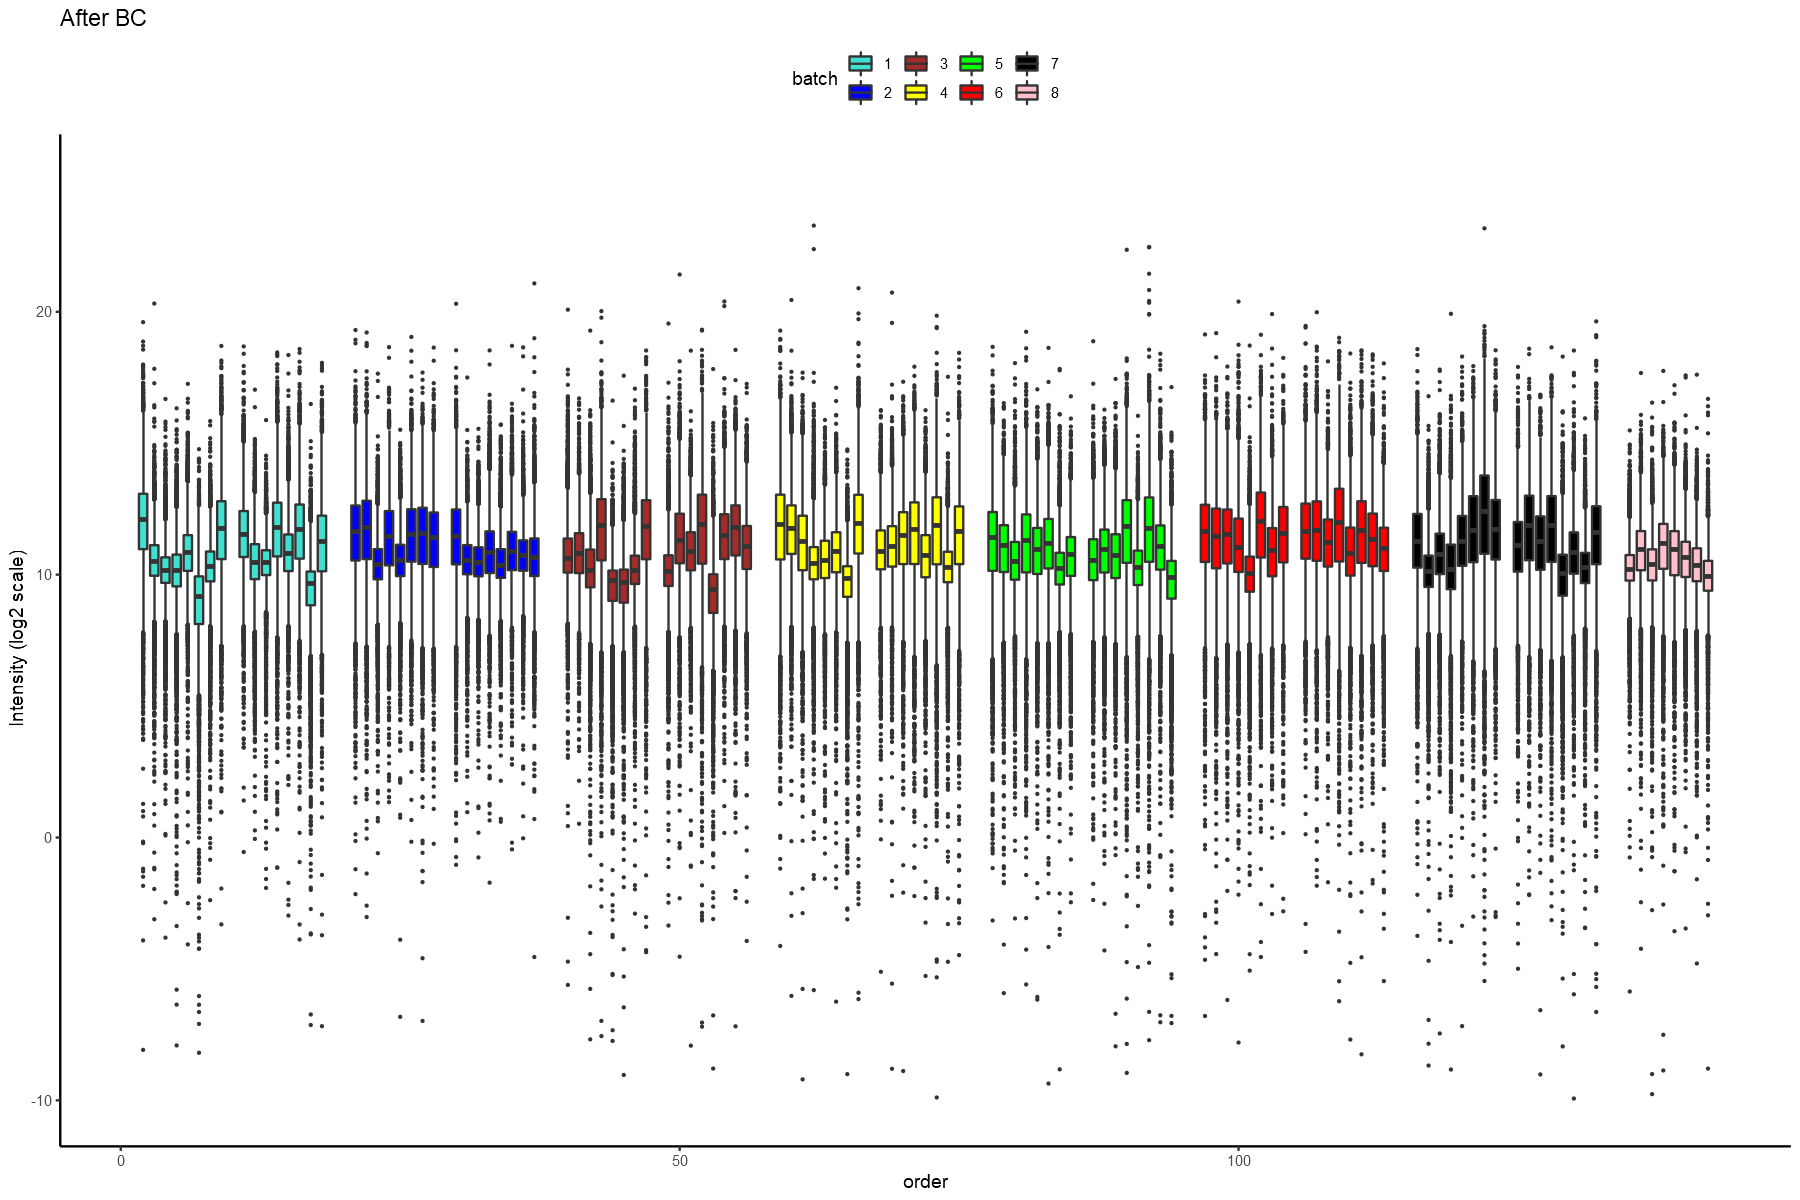

In [46]:
options(repr.plot.width=15, repr.plot.height=10)
plot_boxplot(log2_after_long, meta, sample_id_col = "sample", batch_col = "batch", color_scheme = color_list[["batch"]], ylimits = c(-10,25), plot_title = "After BC") + ylab("Intensity (log2 scale)") # y-range = 35 for comparison purpose

Warning message in check_sample_consistency(sample_annotation, sample_id_col, df_long, :
"Sample IDs in sample annotation not consistent with samples in 
input data, 
              will merge, using intersecting Sample IDs only"
Merging data matrix and sample annotation

Warning message:
"Removed 169 rows containing non-finite values (stat_boxplot)."


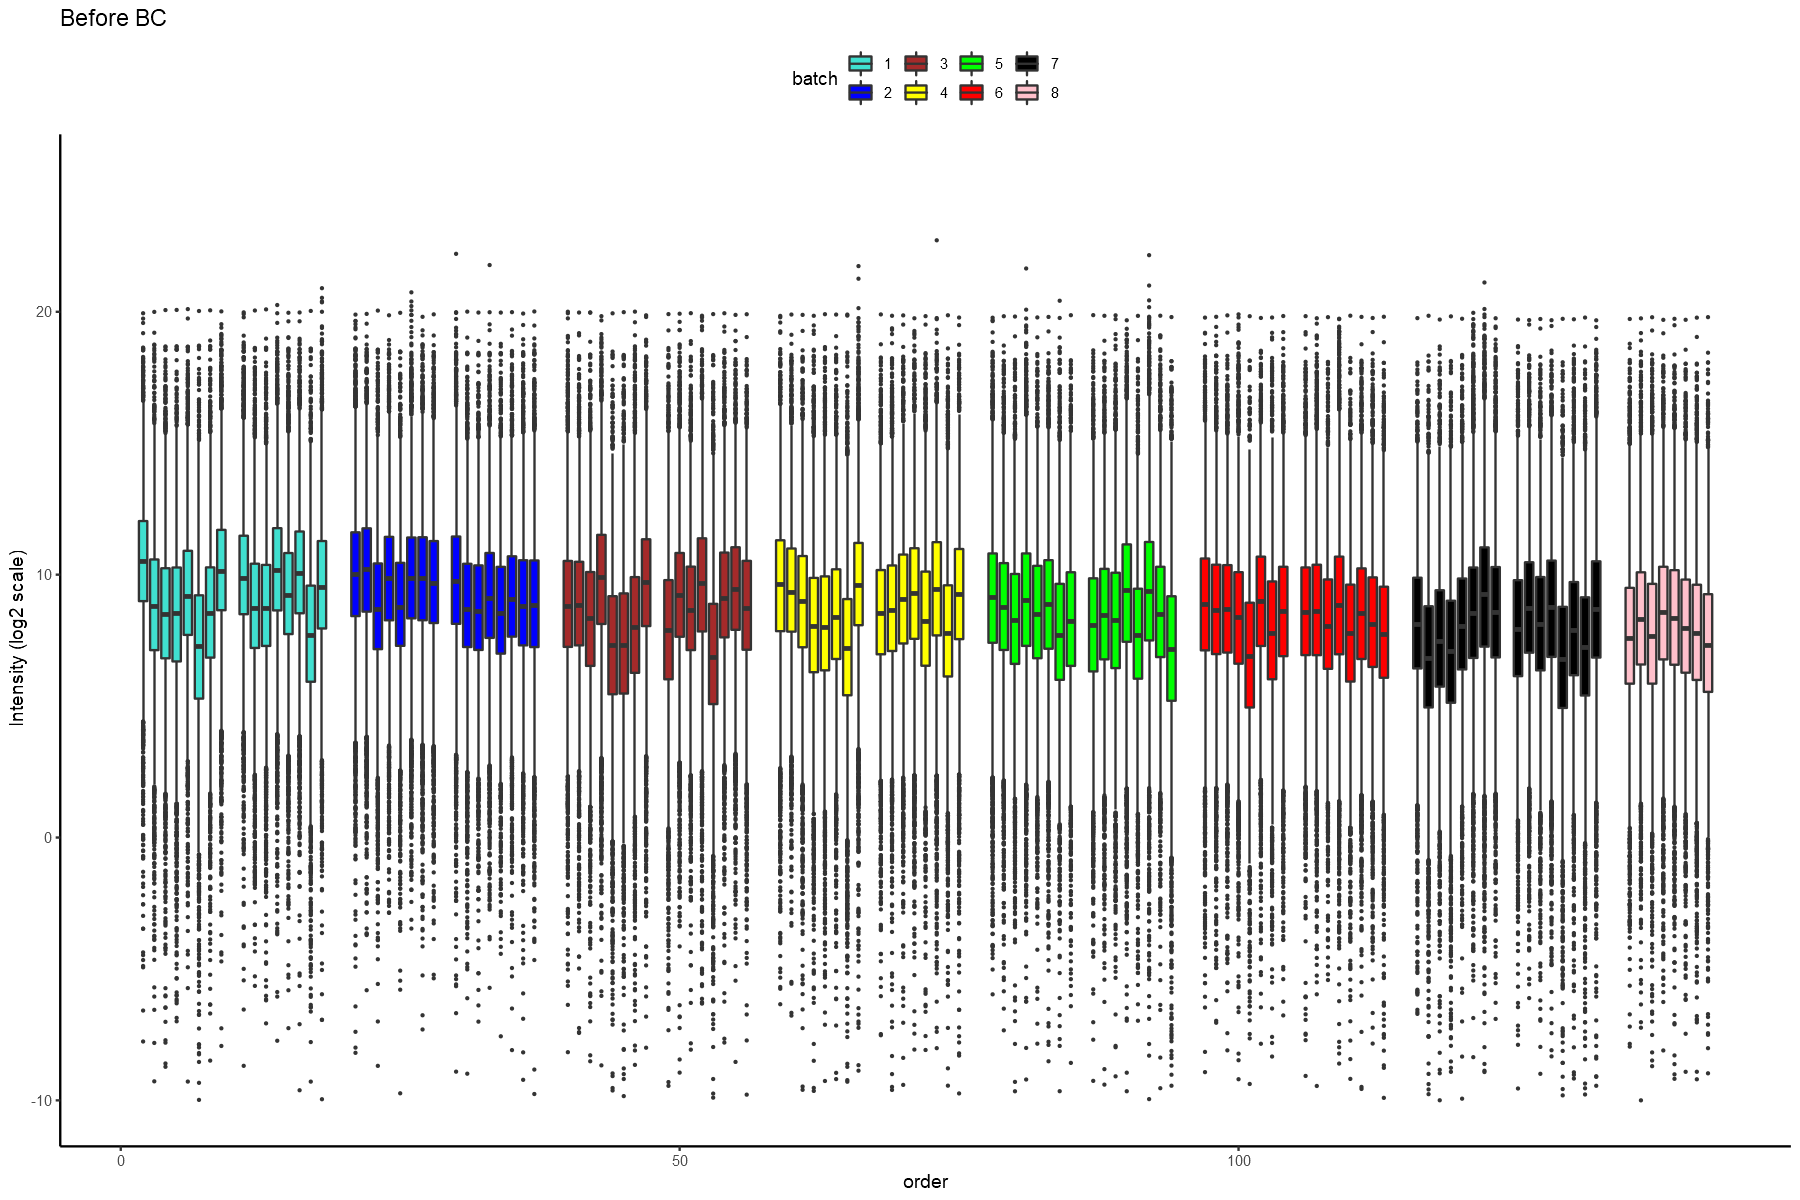

In [47]:
options(repr.plot.width=15, repr.plot.height=10)
plot_boxplot(log2_before_long, meta, sample_id_col = "sample", batch_col = "batch", color_scheme = color_list[["batch"]], ylimits = c(-10,25), plot_title = "Before BC") + ylab("Intensity (log2 scale)") # y-range = 35 for comparison purpose

Conclusion: The peak intensities of samples are significantly more consistent within batches and across. 